In [1]:
import torchtext
import torch
from torchtext.data.utils import get_tokenizer
from collections import Counter
from torchtext.vocab import Vocab, vocab
from torchtext.utils import download_from_url, extract_archive
from torchtext.data.metrics import bleu_score
import io

import random
from typing import Tuple

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch import Tensor
import matplotlib.pyplot as plt
import pdb

import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
import pytorch_lightning as pl
import os
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
import random
from functools import partial

## Saved models:
- version 0 -> not using tanH activation in the outer layer, noise -1, 1, (94 bleu)

- version 1 -> using 50% of min and max noise (overfitting, and loss not decreasing)
- version 2 -> using 10% noise (bleu - 94)

In [19]:
import pandas as pd
pth = '/home/bishwa/v_6/logs_pretraining/csv_file/version_2/metrics.csv'
df = pd.read_csv(pth)
df.head()

,val_loss,epoch,step,train_loss_epoch,train_loss_step
0,5.375754,0,28,NaN,NaN
1,NaN,0,28,7.116383,NaN
2,NaN,1,49,NaN,5.189822
3,5.120662,1,57,NaN,NaN
4,NaN,1,57,5.318600,NaN


/tmp/ipykernel_391823/2168140898.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_loss.dropna(inplace=True)
/tmp/ipykernel_391823/2168140898.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_loss.dropna(inplace=True)


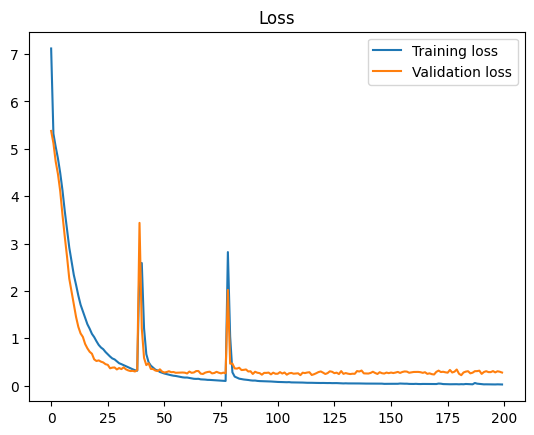

In [20]:
import matplotlib.pyplot as plt
val_loss = df[['epoch', 'val_loss']]
val_loss.dropna(inplace=True)

train_loss = df[['epoch', 'train_loss_epoch']]
train_loss.dropna(inplace=True)

epochs = val_loss['epoch'].tolist()
plt.plot(epochs, train_loss['train_loss_epoch'].tolist(), label='Training loss')
plt.plot(epochs, val_loss['val_loss'].tolist(), label='Validation loss')
plt.title('Loss')
plt.legend()
plt.show()

In [22]:
def download_data():
    url_base = 'https://raw.githubusercontent.com/multi30k/dataset/master/data/task1/raw/'
    train_urls = ('train.de.gz', 'train.en.gz')
    val_urls = ('val.de.gz', 'val.en.gz')
    test_urls = ('test_2016_flickr.de.gz', 'test_2016_flickr.en.gz')

    train_filepaths = [extract_archive(download_from_url(url_base + url))[0] for url in train_urls]
    val_filepaths = [extract_archive(download_from_url(url_base + url))[0] for url in val_urls]
    test_filepaths = [extract_archive(download_from_url(url_base + url))[0] for url in test_urls]

    return train_filepaths, val_filepaths, test_filepaths


def preprocess(text):
    text = text.lower()
    text = re.sub(r'\+d', '', text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = text.strip()
    return text

def build_vocab(filepath, tokenizer):
    counter = Counter()
    with io.open(filepath, encoding="utf8") as f:
        for string_ in f:
            counter.update(tokenizer(preprocess(string_)))
  
    v = vocab(counter, specials=['<unk>', '<pad>', '<sos>', '<eos>'], special_first=True)
    v.set_default_index(0)
    return v

def data_process(filepaths, en_vocab, en_tokenizer):
    raw_en_iter = iter(io.open(filepaths[1], encoding="utf8"))
    data = []
    for raw_en in raw_en_iter:
        en_token = [en_vocab[token] for token in en_tokenizer(preprocess(raw_en))][:13]
        if len(en_token) != 13:
            en_token.extend((13-len(en_token))*[1])
        en_tensor_ = torch.tensor(en_token,
                                dtype=torch.long)
        data.append((en_tensor_, en_tensor_))
    return data

def generate_batch(data_batch, BOS_IDX, EOS_IDX):
  de_batch, en_batch = [], []
  for (de_item, en_item) in data_batch:
    de_batch.append(torch.cat([torch.tensor([BOS_IDX]), de_item, torch.tensor([EOS_IDX])], dim=0))
    en_batch.append(torch.cat([torch.tensor([BOS_IDX]), en_item, torch.tensor([EOS_IDX])], dim=0))

  de_batch = pad_sequence(de_batch, padding_value=1)
  en_batch = pad_sequence(en_batch, padding_value=1)
  return de_batch, en_batch


class Encoder(nn.Module):
    def __init__(self,
                 input_dim: int,
                 emb_dim: int,
                 enc_hid_dim: int,
                 dec_hid_dim: int,
                 dropout: float):
        super().__init__()

        self.input_dim = input_dim
        self.emb_dim = emb_dim
        self.enc_hid_dim = enc_hid_dim
        self.dec_hid_dim = dec_hid_dim
        self.dropout = dropout

        self.embedding = nn.Embedding(input_dim, emb_dim)

#         self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional = True) #changed
        self.rnn = nn.GRU(emb_dim, enc_hid_dim)

#         self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim) #changed
        self.layer_norm_h = nn.LayerNorm(self.emb_dim)
        self.layer_norm_out = nn.LayerNorm(self.emb_dim)
        self.layer_norm_1 = nn.LayerNorm(self.emb_dim)
        self.layer_norm_2 = nn.LayerNorm(self.emb_dim)
        self.fc = nn.Linear(enc_hid_dim, dec_hid_dim)
        self.fc_2 = nn.Linear(enc_hid_dim, dec_hid_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self,
                src: Tensor) -> Tuple[Tensor]:
#         print(src.shape)
        embedded = self.dropout(self.embedding(src))
#         print("Source shape: ", src.shape)
        outputs, hidden = self.rnn(embedded)
#         print("H1 shape: ", hidden.shape)
#         hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))) #changed
        hidden = self.layer_norm_h(hidden)
        outputs = self.layer_norm_out(outputs)
        hidden = self.fc(hidden)
        hidden = self.layer_norm_1(hidden)
#         hidden = torch.tanh(hidden)
        outputs = self.fc_2(outputs)
        outputs = self.layer_norm_2(outputs)
#         outputs = torch.tanh(outputs)
        outputs = torch.cat((outputs, hidden), dim=0)
        return outputs


class Attention(nn.Module):
    def __init__(self,
                 enc_hid_dim: int,
                 dec_hid_dim: int,
                 attn_dim: int):
        super().__init__()

        self.enc_hid_dim = enc_hid_dim
        self.dec_hid_dim = dec_hid_dim

#         self.attn_in = (enc_hid_dim * 2) + dec_hid_dim changed
        self.attn_in = enc_hid_dim + dec_hid_dim
        self.attn = nn.Linear(self.attn_in, attn_dim)

    def forward(self,
                decoder_hidden: Tensor,
                encoder_outputs: Tensor) -> Tensor:

        src_len = encoder_outputs.shape[0]
#         pdb.set_trace()
        repeated_decoder_hidden = decoder_hidden.unsqueeze(1).repeat(1, src_len, 1)

        encoder_outputs = encoder_outputs.permute(1, 0, 2)

        energy = torch.tanh(self.attn(torch.cat((
            repeated_decoder_hidden,
            encoder_outputs),
            dim = 2)))

        attention = torch.sum(energy, dim=2)
#         pdb.set_trace()
        return F.softmax(attention, dim=1)


def random_noise(x, min_value, max_value):
    noise = torch.rand(x.shape) * (max_value - min_value) + min_value
    return noise.type_as(x)

class Decoder(nn.Module):
    def __init__(self,
                 output_dim: int,
                 emb_dim: int,
                 enc_hid_dim: int,
                 dec_hid_dim: int,
                 dropout: int,
                 attention: nn.Module):
        super().__init__()

        self.emb_dim = emb_dim
        self.enc_hid_dim = enc_hid_dim
        self.dec_hid_dim = dec_hid_dim
        self.output_dim = output_dim
        self.dropout = dropout
        self.attention = attention

        self.embedding = nn.Embedding(output_dim, emb_dim)
#         self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim) changed
        self.rnn = nn.GRU(enc_hid_dim + emb_dim, dec_hid_dim)
        self.layer_norm_h = nn.LayerNorm(self.emb_dim)
        self.layer_norm_o = nn.LayerNorm(self.emb_dim)
        self.layer_norm_r = nn.LayerNorm(self.emb_dim)
        self.out = nn.Linear(self.attention.attn_in + emb_dim, output_dim)

        self.dropout = nn.Dropout(dropout)


    def _weighted_encoder_rep(self,
                              decoder_hidden: Tensor,
                              encoder_outputs: Tensor) -> Tensor:
#         pdb.set_trace()
        a = self.attention(decoder_hidden, encoder_outputs)

        a = a.unsqueeze(1)

        encoder_outputs = encoder_outputs.permute(1, 0, 2)

        weighted_encoder_rep = torch.bmm(a, encoder_outputs)

        weighted_encoder_rep = weighted_encoder_rep.permute(1, 0, 2)

        return weighted_encoder_rep


    def forward(self,
                input: Tensor,
                decoder_hidden: Tensor,
                encoder_outputs: Tensor) -> Tuple[Tensor]:
        
        input = input.unsqueeze(0) # 128
        # hidden -> 128, 64
        # de
        embedded = self.dropout(self.embedding(input))
        
        weighted_encoder_rep = self._weighted_encoder_rep(decoder_hidden,
                                                          encoder_outputs)

        rnn_input = torch.cat((embedded, weighted_encoder_rep), dim = 2)
#         pdb.set_trace()
        output, decoder_hidden = self.rnn(rnn_input, decoder_hidden.unsqueeze(0))
        output = self.layer_norm_o(output)
        decoder_hidden = self.layer_norm_h(decoder_hidden)
        weighted_encoder_rep = self.layer_norm_r(weighted_encoder_rep)

        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted_encoder_rep = weighted_encoder_rep.squeeze(0)

        output = self.out(torch.cat((output,
                                     weighted_encoder_rep,
                                     embedded), dim = 1))

        return output, decoder_hidden.squeeze(0)
    

class AutoEncoder(pl.LightningModule):
  def __init__(self, encoder, decoder, teacher_forcing=0.5):
    super().__init__()
    self.encoder = encoder
    self.decoder = decoder
    self.loss_fn = nn.CrossEntropyLoss(ignore_index=1)
    self.teacher_forcing = teacher_forcing
  
  def forward(self, x):
    return self.model(x)

  def training_step(self, batch, batch_index):
    src, trg = batch
    batch_size = src.shape[1]
    max_len = trg.shape[0]
    trg_vocab_size = self.decoder.output_dim

    outputs = torch.zeros(max_len, batch_size, trg_vocab_size)
    outputs = outputs.type_as(src)
    outputs = outputs.type(torch.float32)
    encoder_outputs = self.encoder(src)
    encoder_outputs = encoder_outputs + random_noise(encoder_outputs, -0.5, 0.5)
    hidden = encoder_outputs[max_len, :, :]
    encoder_outputs = encoder_outputs[:max_len, :, :]
    output = trg[0,:]
    for t in range(1, max_len):
        output, hidden = self.decoder(output, hidden, encoder_outputs)
        outputs[t] = output
        teacher_force = random.random() < self.teacher_forcing
        top1 = output.max(1)[1]
        output = (trg[t] if teacher_force else top1)
    
    output = outputs[1:].view(-1, outputs.shape[-1])
    # output = output.type(torch.int64)
    trg = trg[1:].view(-1)
    # trg = trg.type(torch.int64)
    loss = self.loss_fn(output, trg)
    # loss = F.cross_entropy(output, trg)
    self.log("train_loss", loss, on_epoch=True)
    return loss

  def validation_step(self, batch, batch_index):
    src, trg = batch
    batch_size = src.shape[1]
    max_len = trg.shape[0]
    trg_vocab_size = self.decoder.output_dim

    outputs = torch.zeros(max_len, batch_size, trg_vocab_size)
    outputs = outputs.type_as(src)
    outputs = outputs.type(torch.float32)
    encoder_outputs = self.encoder(src)
    encoder_outputs = encoder_outputs + random_noise(encoder_outputs, -0.5, 0.5)
    hidden = encoder_outputs[max_len, :, :]
    encoder_outputs = encoder_outputs[:max_len, :, :]
    output = trg[0,:]
    for t in range(1, max_len):
        output, hidden = self.decoder(output, hidden, encoder_outputs)
        outputs[t] = output
        teacher_force = random.random() < self.teacher_forcing
        top1 = output.max(1)[1]
        output = (trg[t] if teacher_force else top1)
    
    output = outputs[1:].view(-1, outputs.shape[-1])
    trg = trg[1:].view(-1)
    loss = self.loss_fn(output, trg)
    # loss = F.cross_entropy(output, trg)
    self.log("val_loss", loss, on_epoch=True)
    return loss

  def test_step(self, batch, batch_idx):
    src, trg = batch
    batch_size = src.shape[1]
    max_len = trg.shape[0]
    trg_vocab_size = self.decoder.output_dim

    outputs = torch.zeros(max_len, batch_size, trg_vocab_size)
    outputs = outputs.type_as(src)
    outputs = outputs.type(torch.float32)
    encoder_outputs = self.encoder(src)
    encoder_outputs = encoder_outputs + random_noise(encoder_outputs, -2, 2)
    hidden = encoder_outputs[max_len, :, :]
    encoder_outputs = encoder_outputs[:max_len, :, :]
    output = trg[0,:]
    for t in range(1, max_len):
        output, hidden = self.decoder(output, hidden, encoder_outputs)
        outputs[t] = output
        teacher_force = random.random() < self.teacher_forcing
        top1 = output.max(1)[1]
        output = (trg[t] if teacher_force else top1)
    
    output = outputs[1:].view(-1, outputs.shape[-1])
    trg = trg[1:].view(-1)
    loss = self.loss_fn(output, trg)
    # loss = F.cross_entropy(output, trg)
    self.log("test_loss", loss)
    return loss

  def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
    return optimizer
    
  def predict_step(self, batch, batch_idx):
    src, trg = batch
    batch_size = src.shape[1]
    max_len = trg.shape[0]
    trg_vocab_size = self.decoder.output_dim

    outputs = torch.zeros(max_len, batch_size, trg_vocab_size)
    outputs = outputs.type_as(src)
    outputs = outputs.type(torch.float32)
    encoder_outputs = self.encoder(src)
    encoder_outputs = encoder_outputs + random_noise(encoder_outputs, -2, 2)
    hidden = encoder_outputs[max_len, :, :]
    encoder_outputs = encoder_outputs[:max_len, :, :]
    output = trg[0,:]
    for t in range(1, max_len):
        output, hidden = self.decoder(output, hidden, encoder_outputs)
        outputs[t] = output
        teacher_force = random.random() < self.teacher_forcing
        top1 = output.max(1)[1]
        output = (trg[t] if teacher_force else top1)
    
    outputs = outputs.type(torch.int)
    outputs = torch.transpose(outputs, -1, 0)
    outputs = outputs.detach().cpu().numpy().tolist()
    return outputs
  

In [23]:
en_tokenizer = get_tokenizer('spacy', language='en_core_web_sm')
wordnet = WordNetLemmatizer()

train_filepaths, val_filepaths, test_filepaths = download_data()
en_vocab = build_vocab(train_filepaths[1], en_tokenizer)

train_data = data_process(train_filepaths, en_vocab, en_tokenizer)
val_data = data_process(val_filepaths, en_vocab, en_tokenizer)
test_data = data_process(test_filepaths, en_vocab, en_tokenizer)

BATCH_SIZE = 1024
PAD_IDX = en_vocab['<pad>']
BOS_IDX = en_vocab['<sos>']
EOS_IDX = en_vocab['<eos>']

train_iter = DataLoader(train_data, batch_size=BATCH_SIZE,
                    shuffle=True, collate_fn=partial(generate_batch, BOS_IDX=BOS_IDX, EOS_IDX= EOS_IDX))
valid_iter = DataLoader(val_data, batch_size=BATCH_SIZE,
                        shuffle=True, collate_fn=partial(generate_batch, BOS_IDX=BOS_IDX, EOS_IDX= EOS_IDX))
test_iter = DataLoader(test_data, batch_size=BATCH_SIZE,
                    shuffle=True, collate_fn=partial(generate_batch, BOS_IDX=BOS_IDX, EOS_IDX= EOS_IDX))


INPUT_DIM = len(en_vocab)
OUTPUT_DIM = len(en_vocab)

ENC_EMB_DIM = 64
DEC_EMB_DIM = 64
ENC_HID_DIM = 64
DEC_HID_DIM = 64
ATTN_DIM = 8
ENC_DROPOUT = 0.6
DEC_DROPOUT = 0.6
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT).to(device)

attn = Attention(ENC_HID_DIM, DEC_HID_DIM, ATTN_DIM).to(device)

dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn).to(device)

# autoencoder = AutoEncoder(encoder=enc, decoder=dec)

In [24]:
chkpt = "/home/bishwa/v_6/logs_pretraining/csv_file/version_2/checkpoints/epoch=199-step=5800.ckpt"
endtoend = AutoEncoder.load_from_checkpoint(chkpt, encoder=enc, decoder=dec)
trainer = pl.Trainer()
# trainer.test(endtoend, dataloaders=train_iter)
# trainer.predict(endtoend, dataloaders=valid_iter)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/anaconda3/envs/bishwa_torch/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=3)`.
  rank_zero_warn(


In [31]:
def predict(model, sen):
    enc = model.encoder
    dec = model.decoder
    torch.save(enc.state_dict(), './saved_pretrained_model/encoder_13_noise_10p_bleu_94.pth')
    torch.save(dec.state_dict(), './saved_pretrained_model/decoder_13_noise_10p_bleu_94.pth')
    enc.eval()
    dec.eval()
    
    batch_size = sen.shape[1]
    max_len = sen.shape[0]
    trg_vocab_size = dec.output_dim

    outputs = torch.zeros(max_len, batch_size)
    with torch.no_grad():
        encoder_outputs = enc(sen)

        # first input to the decoder is the <sos> token
        output = sen[0,:]
        min_, max_ = float(torch.min(encoder_outputs)), float(torch.max(encoder_outputs))
        min_, max_ = 0.1*min_, 0.1*max_
        encoder_outputs = encoder_outputs + random_noise(encoder_outputs, min_, max_).to(device)
        hidden = encoder_outputs[max_len, :, :]
        encoder_outputs = encoder_outputs[:max_len, :, :]
#         hidden = hidden + normal_noise(hidden.shape).to(device)
        for t in range(1, max_len):
            output, hidden = dec(output, hidden, encoder_outputs)
            top1 = output.max(1)[1]
            outputs[t] = top1
            output = top1
    
    outputs = outputs.type(torch.int)
    outputs = torch.transpose(outputs, -1, 0)
    outputs = outputs.detach().cpu().numpy().tolist()
    return outputs

In [32]:
def translate_sentence(sentence, train_data=False):
    if not train_data:
        if type(sentence) == str:
            tokens = torch.tensor([en_vocab[token] for token in en_tokenizer(sentence)],
                          dtype=torch.long)
            tokens = torch.cat([torch.tensor([BOS_IDX]), tokens, torch.tensor([EOS_IDX])], dim=0)
        else:
            tokens = [token.lower() for token in sentence]
            
        sentence = torch.LongTensor(tokens).unsqueeze(0).to(device)
        sentence_tensor = torch.transpose(sentence, -1, 0)  
        trg_len = sentence_tensor.shape[0]
        
#         encoder_outputs, hidden = enc(sentence_tensor)
        
#         output = sen[0, :]
        
#         for t in range(1, trg_len):
#             output, hidden = dec(output, hidden, encoder)
        outputs = predict(endtoend, sentence_tensor)
#         pdb.set_trace()
        translated_sentence = en_vocab.lookup_tokens(outputs[0])
        return outputs, ' '.join(x for x in translated_sentence[1:])
    else: 
        sentence = sentence.to(device)
        outputs = predict(endtoend, sentence)
        translated_sentence = []
        input_sentence = []
#         pdb.set_trace()
        inputs = torch.transpose(sentence, -1, 0)
        inputs = inputs.detach().cpu().numpy().tolist()
        batch_size = sentence.shape[1]
        
        for i in range(batch_size):
            token_ = outputs[i]
            in_ = inputs[i]
            sen = en_vocab.lookup_tokens(token_)
            in_sen = en_vocab.lookup_tokens(in_)
            translated_sentence.append(' '.join(x for x in sen[1:]))
            input_sentence.append(' '.join(x for x in in_sen[1:]))

        return input_sentence, translated_sentence

In [33]:
sent = next(iter(valid_iter))[0]

In [34]:
in_sen, predicted = translate_sentence(sent, True)

for i in range(len(predicted)):
    print("Input: ", in_sen[i].split('<eos>')[0].split('<pad>')[0].strip())
    print("Output: ", predicted[i].split('<eos>')[0][: len(in_sen[i].split('<eos>')[0].split('<pad>')[0].strip())])
    print("**"*20)

Input:  a man pulls on his sweater as a kayak lays at his feet
Output:  a man pulls on his sweater as a kayak lays at his feet
****************************************
Input:  a man in a cluttered office is using the telephone
Output:  a man in a cluttered office is using the telephone
****************************************
Input:  a man slouched in a chair on a city sidewalk girl watching
Output:  a man couples in a chair on a city sidewalk girl watching 
****************************************
Input:  a young blond boy is jumping from bed to bed
Output:  a young blond boy is jumping from bed to bed
****************************************
Input:  a young man in a green sweatshirt reads a newspaper on the beach
Output:  a young man in a green sweatshirt reads a newspaper on the beach
****************************************
Input:  a young boy wearing a giants jersey swings a baseball bat at an
Output:  a young boy wearing a turquoise jersey swings a baseball bat at
***************

In [35]:
def calculate_blue_score(input_sentence, predicted_sentence):
    input_token = []
    predicted_token = []
    for in_, pre_ in zip(input_sentence, predicted_sentence):
        input_sen = in_.split('<eos>')[0].split('<pad>')[0]
        predicted_sen = pre_.split('<eos>')[0][: len(input_sen)]
        
        input_token.append([input_sen.split(' ')])
        predicted_token.append(predicted_sen.split(' '))
        
    return bleu_score(predicted_token, input_token)

In [36]:
calculate_blue_score(in_sen, predicted)

0.9464287691654246